In [1]:
import numpy as np
import pandas as pd

# Dataset
- Vamos utilizar um dataset de reviews de filmes no IMDB traduzidos para o português. O dataset esta disponível no [kaggle](https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr?select=imdb-reviews-pt-br.csv)

In [2]:
#data = pd.read_csv('imdb-reviews-pt-br.csv')
#data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'imdb-reviews-pt-br.csv'

In [ ]:
data.sentiment.value_counts()

neg    24765
pos    24694
Name: sentiment, dtype: int64

- Os dados estão bem balanceados, praticamente metade com sentimento positivo e outra metade com sentimento negativo.

In [ ]:
import re

# Extração de Features
- Para extração de features vamos utilizar o Count Vectorizer da biblioteca sklearn, retirando stop words e utilizando o tokenizador da biblioteca NLTK.

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('portuguese'))
stop_words.update(['que', 'até', 'esse',
                    'essa', 'pro', 'pra',
                    'oi'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Limpeza dos dados
- Uma função para a limpeza de dados que estamos usando desde do primeiro laboratório. Nessa função colocamos todas as palavras em lower case, retiramos dígitos, sinais de pontuação, espaços duplicados e strings com menos de 3 caracteres.


In [ ]:
def clean_text(text):
  text = text.lower()
  text = re.sub("^\d+\s|\s\d+\s|\s\d+$", "", text)
  text = re.sub('[,.!?;:/_]', '', text)
  text = ' '.join(i for i in text.split() if not(i in stop_words) and len(i) > 2 and (not any (c.isdigit() for c in i)))

  return text

In [ ]:
data['text_pt_clean'] = data.text_pt.apply(clean_text)

In [ ]:
data.text_pt_clean[0]

'vez costner arrumou filme tempo necessário além terríveis seqüências resgate mar quais poucas simplesmente importei nenhum personagens maioria fantasmas armário personagem costers realizado logo início esquecido tarde importava personagem deveríamos importar arrogante superconfiante ashton kutcher problema sai garoto pensa melhor qualquer outra pessoa redor mostra sinais armário desordenado único obstáculo parece vencendo costner finalmente bem além meio caminho costner conta sobre fantasmas kutchers informados kutcher levado melhor pressentimentos presságios anteriores nenhuma mágica aqui tudo podia fazer desligar hora'

### Criando o Count Vectorizer
- Vamos criar nosso vetor esparso com as palavras e suas ocorrências a fim de treinar os modelos futuramente

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

count_vectorizer = CountVectorizer(ngram_range = (1,2))
text_counts = count_vectorizer.fit_transform(data.text_pt_clean)

In [ ]:
text_counts.shape

(49459, 3309400)

# Separação dos dados
- Vamos separar os dados entre dados de treino e teste. A parte dos dados referente ao treino é maior que a parte de dados referente a validação. Essa separação é feita com o propósito de validar o mdoelo criado e treinado com os dados que temos.
- É importante saber quem é X e Y. Geralmente chamamos de X os dados textuais, e Y as labels, que no nosso caso são neg e pos, ou 0 e 1.

In [ ]:
data['sentiment_bin'] = [0 if i == 'neg' else 1 for i in data['sentiment']]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(text_counts,data.sentiment_bin,test_size = 0.33, random_state=0)

# Criação dos Modelos
### Naive Bayes
- Vamos iniciar utilizando um modelo Naive Bayes da sklearn para classificar os reviews de filmes no IMDB. Será utilizado o [MultinomialNBClassifier](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes), mas [aqui](https://scikit-learn.org/stable/modules/naive_bayes.html#) você poderá ver algumas variações.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()


In [ ]:
# treinando o modelo com os dados e as labels de treino
MNB.fit(X_train, Y_train)

MultinomialNB()

In [ ]:
# fazendo a predição com os dados de teste
from sklearn import metrics
predicted = MNB.predict(X_test)
predicted[0:10]


array([1, 0, 0, 1, 1, 1, 0, 0, 0, 1])

### Métricas
- Temos algumas métricas que podemos avaliar os modelos que geramos e sua acertividade.
  - Acurácia: a quantidade de acertos do nosso modelo divido pelo total da amostra. Com ela queremos responder a seguinte pergunta: o quão certo meu modelo está?

  - Precisão: de todos os dados classificados como positivos, quantos são realmente positivos. Essa métrica indica quantos falsos positivos (ou negativos) tivemos na predição.

  -  Recall: qual a porcentagem de dados classificados como positivos comparado com a quantidade real de positivos que existem em nossa amostra. Basicamente, quantos positivos foram realmente classificados como positivos.

  - f1-score: essa métrica une precisão e recall afim de trazer um número único que determine a qualidade geral do nosso modelo.


Esse resumo foi retirado de um [post](https://medium.com/@mateuspdua/machine-learning-m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-acur%C3%A1cia-precis%C3%A3o-e-recall-d44c72307959) do medium.
      
      

In [ ]:
# acurácia do modelo naive bayes
accuracy_score = metrics.accuracy_score(predicted, Y_test)
accuracy_score

0.8821835559367724

In [ ]:
print(metrics.classification_report(Y_test, predicted, target_names=["negativo","positivo"]))

              precision    recall  f1-score   support

    negativo       0.87      0.90      0.88      8219
    positivo       0.89      0.86      0.88      8103

    accuracy                           0.88     16322
   macro avg       0.88      0.88      0.88     16322
weighted avg       0.88      0.88      0.88     16322



### Matriz de Confusão
- Permite visualizar o desempenho do modelo do algoritmo de classificação. Com a matriz de confusão conseguimos visualizar de forma gráfica a quantidade de acertos, precisão e o número de falsos negativos e positivos da predição realizada.


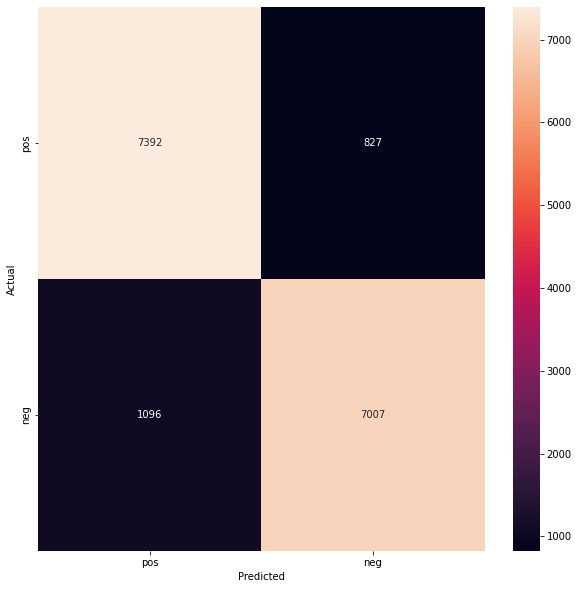

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(Y_test, predicted)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(data.sentiment), yticklabels=set(data.sentiment))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Regressão Logística
- Vamos utilizar um modelo de Regressão Logística da sklearn para classificar os reviews de filmes no IMDB. Será utilizado o [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#examples-using-sklearn-linear-model-logisticregression)

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression(max_iter=300)
LR.fit(X_train, Y_train)

LogisticRegression(max_iter=300)

In [ ]:
# fazendo a predição com os dados de teste
predicted = LR.predict(X_test)
predicted[0:10]

array([1, 0, 0, 1, 1, 1, 0, 0, 0, 1])

In [ ]:
# acurácia do modelo de regressão logística
accuracy_score = metrics.accuracy_score(predicted, Y_test)
accuracy_score

0.8943756892537679

In [ ]:
print(metrics.classification_report(Y_test, predicted, target_names=["negativo","positivo"]))

              precision    recall  f1-score   support

    negativo       0.90      0.88      0.89      8219
    positivo       0.89      0.90      0.89      8103

    accuracy                           0.89     16322
   macro avg       0.89      0.89      0.89     16322
weighted avg       0.89      0.89      0.89     16322



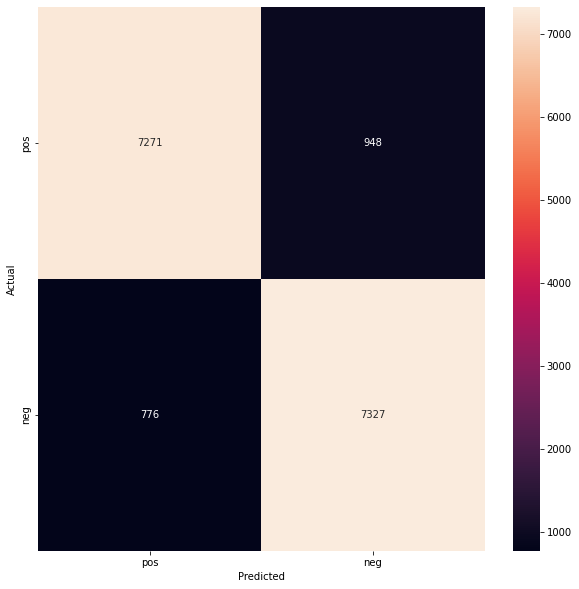

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat = confusion_matrix(Y_test, predicted)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(data.sentiment), yticklabels=set(data.sentiment))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()